In [1]:
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline  

import torch
import torch.nn as nn


import torch.optim as optim

import sys
sys.path.insert(0, '../libraries/')

import mnist_data_lib
import mnist_vae_lib
import mnist_utils

import torchvision.datasets as dset
import torchvision.transforms as transforms
import torch.nn.functional as F


# Load data

In [2]:
train_set_labeled, train_set_unlabeled, test_set = \
    mnist_data_lib.get_mnist_dataset_semisupervised(propn_sample=0.001)

In [3]:
print('num_train_labeled: ', train_set_labeled.num_images)
print('num_train_unlabled: ', train_set_unlabeled.num_images)

print('num_test: ', test_set.num_images)

num_train_labeled:  6
num_train_unlabled:  54
num_test:  10


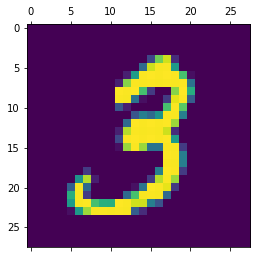

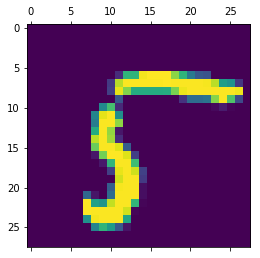

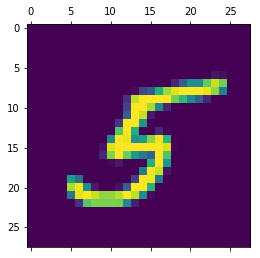

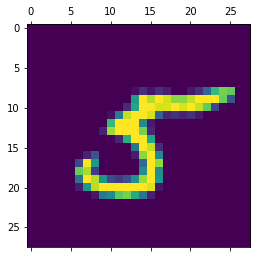

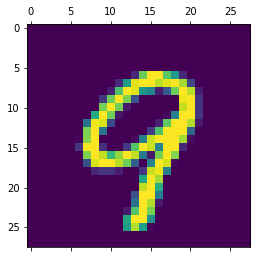

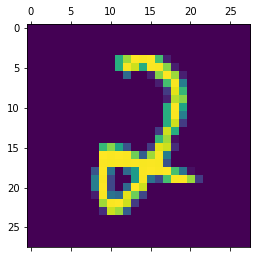

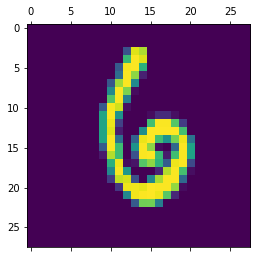

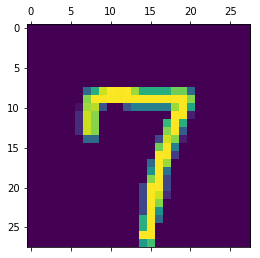

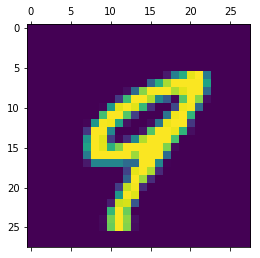

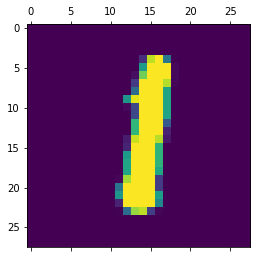

In [4]:
for i in range(10): 
    plt.matshow(train_set_unlabeled[i]['image'].squeeze())
    assert np.all(train_set_unlabeled[i]['image'].detach().numpy() <= 1)
    assert np.all(train_set_unlabeled[i]['image'].detach().numpy() >= 0)

In [5]:
slen = train_set_labeled[0]['image'].shape[0]

# Get data loaders

In [6]:
batchsize = 12

train_loader_labeled = torch.utils.data.DataLoader(
                 dataset=train_set_labeled,
                 batch_size=batchsize,
                 shuffle=True)

train_loader_unlabeled = torch.utils.data.DataLoader(
                 dataset=train_set_unlabeled,
                 batch_size=batchsize,
                 shuffle=True)

test_loader = torch.utils.data.DataLoader(
                dataset=test_set,
                batch_size=batchsize,
                shuffle=False)


In [7]:
for batch_idx, d in enumerate(train_loader_unlabeled):
    data_unlabeled = d
    break
    
for batch_idx, d in enumerate(train_loader_labeled):
    data_labeled = d
    break
    
for batch_idx, d in enumerate(test_loader):
    data_test = d
    break

In [8]:
data_unlabeled['image'].shape

torch.Size([12, 28, 28])

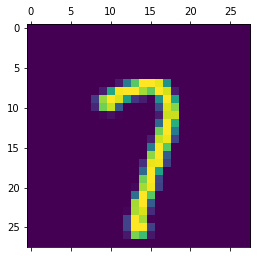

In [9]:
plt.matshow(data_unlabeled['image'][0, :, :])

# Define VAE

In [10]:
latent_dim = 6
n_classes = 10

In [11]:
vae = mnist_vae_lib.HandwritingVAE(latent_dim = latent_dim, 
                                    n_classes = n_classes)

In [12]:
print(vae.parameters)

<bound method Module.parameters of HandwritingVAE(
  (encoder): MLPEncoder(
    (fc1): Linear(in_features=794, out_features=512, bias=True)
    (fc2): Linear(in_features=512, out_features=512, bias=True)
    (fc3): Linear(in_features=512, out_features=256, bias=True)
    (fc4): Linear(in_features=256, out_features=12, bias=True)
  )
  (classifier): Classifier(
    (fc1): Linear(in_features=784, out_features=256, bias=True)
    (fc2): Linear(in_features=256, out_features=256, bias=True)
    (fc3): Linear(in_features=256, out_features=256, bias=True)
    (fc4): Linear(in_features=256, out_features=10, bias=True)
    (log_softmax): LogSoftmax()
  )
  (decoder): MLPConditionalDecoder(
    (fc1): Linear(in_features=16, out_features=256, bias=True)
    (fc2): Linear(in_features=256, out_features=512, bias=True)
    (fc3): Linear(in_features=512, out_features=512, bias=True)
    (fc4): Linear(in_features=512, out_features=784, bias=True)
    (sigmoid): Sigmoid()
  )
)>


In [13]:
28 * 28

784

In [14]:
### Check things run

In [15]:
data_unlabeled['image'].shape

torch.Size([12, 28, 28])

In [16]:
# check dimensions of encoder output

log_class_weights = vae.classifier(data_unlabeled['image'])
assert log_class_weights.shape[0] == batchsize
assert log_class_weights.shape[1] == n_classes 

latent_means, latent_std = \
    vae.encoder(data_unlabeled['image'], log_class_weights)
    
assert latent_means.shape[0] == batchsize
assert latent_means.shape[1] == latent_dim

assert latent_std.shape[0] == batchsize
assert latent_std.shape[1] == latent_dim


In [17]:
cat_rv = torch.distributions.Categorical(probs = torch.exp(log_class_weights))
z_ind = cat_rv.sample()

In [18]:
z_ind

tensor([ 9,  9,  9,  6,  6,  0,  3,  6,  4,  6,  5,  4])

In [19]:
# check one hot encoding 

one_hot_z = mnist_utils.get_one_hot_encoding_from_int(z_ind, n_classes)

for n in range(batchsize): 
    foo = one_hot_z[n, :]
    
    assert foo[z_ind[n]] == 1.
    assert sum(foo) == 1.

In [20]:
# check decoder output size 
image_mean = vae.decoder(latent_means, one_hot_z)
assert image_mean.shape[0] == batchsize
assert image_mean.shape[1] == slen
assert image_mean.shape[1] == slen

In [21]:
# check loss goes through

In [22]:
vae.get_conditional_loss(data_labeled['image'], data_labeled['label'])

tensor([ 543.0206,  543.2745,  543.6105,  543.7845,  543.6306,  543.4738])

In [24]:
vae.get_semisupervised_loss(data_unlabeled['image'],
                            data_labeled['image'], data_labeled['label'], 1000,
                            use_baseline = True,
                            alpha = 1.0, topk = 0)

(tensor(1.00000e+05 *
        5.4437), tensor(6519.9727))

# Check gradient works 

In [25]:
def get_vae_params(vae): 
    vae_params = np.array([])
    for f in vae.parameters(): 
        vae_params = np.append(vae_params, f.detach().numpy().flatten())
    return vae_params


In [26]:
vae_params0 = get_vae_params(vae)

In [27]:
assert np.any(np.isnan(vae_params0)) == False

In [28]:
optimizer = optim.Adam(vae.parameters(), lr=0.01)
optimizer.zero_grad()

In [29]:
loss, map_loss1 = vae.get_semisupervised_loss(data_unlabeled['image'],
                            data_labeled['image'], data_labeled['label'], 100, 
                            use_baseline = True,
                            alpha = 1.0, topk = 0)
print(map_loss1)

tensor(6519.9424)


In [30]:
loss.backward()
optimizer.step()

In [31]:
vae_params1 = get_vae_params(vae)

In [32]:
assert np.any(np.isnan(vae_params1)) == False

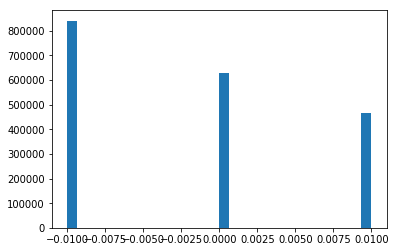

In [33]:
plt.hist(vae_params1 - vae_params0, bins = 30); 

In [34]:
loss, map_loss2 = vae.get_semisupervised_loss(data_unlabeled['image'],
                            data_labeled['image'], data_labeled['label'], 100,
                            use_baseline = True,
                            alpha = 1.0, topk = 0)


In [35]:
map_loss2

tensor(3265.5486)

In [36]:
assert np.isfinite(loss.detach().numpy())

# Test training

In [37]:
from torch.utils.data.sampler import Sampler

In [38]:
mnist_vae_lib.train_semisupervised_model(vae, train_loader_unlabeled, 
                                        data_labeled['image'], 
                                        data_labeled['label'], 
                                        test_loader, 
                                        n_epoch = 5, print_every = 2, outfile = './test', 
                                        use_true_labels = True)

  * init train recon loss: 316.833374;
  * init test recon loss: 254.3592072;
  * init train class accuracy: 0.09259;
  * init test class accuracy:  0.2;
[1] unlabeled_loss: 214.0993958  	[0.2 seconds]
[2] unlabeled_loss: 146.3475342  	[0.2 seconds]
  * train recon loss: 136.4098358;
  * test recon loss: 131.2333069;
  * train class accuracy: 0.2037;
  * test class accuracy:  0.1;
[3] unlabeled_loss: 140.7359619  	[0.2 seconds]
[4] unlabeled_loss: 131.4669342  	[0.2 seconds]
  * train recon loss: 128.8648987;
  * test recon loss: 125.5543671;
  * train class accuracy: 0.3889;
  * test class accuracy:  0.4;
[5] unlabeled_loss: 130.2972565  	[0.2 seconds]
writing the encoder parameters to ./test_enc_final

writing the decoder parameters to ./test_dec_final

writing the classifier parameters to ./test_classifier_final



In [39]:
torch.exp(vae.classifier(data_unlabeled['image']).detach())

tensor([[ 1.6465e-02,  2.8954e-01,  3.8154e-06,  3.5170e-04,  4.7123e-06,
          1.1967e-02,  1.2390e-04,  3.9366e-01,  2.8783e-01,  4.9345e-05],
        [ 5.6641e-05,  3.6542e-01,  5.0773e-11,  1.7012e-07,  5.9604e-11,
          1.2303e-03,  2.3091e-08,  1.0904e-04,  6.3318e-01,  1.6571e-09],
        [ 6.4172e-02,  1.0850e-01,  1.0156e-06,  1.3070e-04,  1.1293e-06,
          4.0515e-03,  3.3634e-05,  7.7275e-01,  5.0344e-02,  1.6602e-05],
        [ 3.9549e-02,  4.8948e-01,  1.5817e-09,  3.3323e-06,  1.6712e-09,
          8.2526e-02,  5.3009e-07,  9.4810e-02,  2.9363e-01,  8.9792e-08],
        [ 5.2762e-03,  8.4968e-01,  3.3874e-05,  1.2551e-03,  3.8515e-05,
          1.3877e-02,  4.5216e-04,  7.7313e-03,  1.2150e-01,  1.5191e-04],
        [ 8.1091e-02,  3.6846e-01,  4.3667e-06,  3.4810e-04,  4.0406e-06,
          2.4878e-02,  9.2995e-05,  4.5108e-02,  4.7998e-01,  3.0823e-05],
        [ 6.1571e-03,  6.4410e-01,  1.9408e-06,  2.3563e-04,  2.6099e-06,
          1.2482e-02,  7.3003e-0

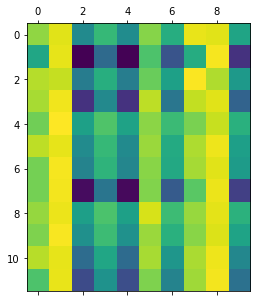

In [40]:
plt.matshow(vae.classifier(data_unlabeled['image']).detach())

In [41]:
# check reloading

In [42]:
reload_vae = vae = mnist_vae_lib.HandwritingVAE(latent_dim = latent_dim, 
                                    n_classes = n_classes)

In [43]:
enc_file = "./test_enc_final"
dec_file = './test_dec_final'

reload_vae.encoder.load_state_dict(torch.load(enc_file,
                               map_location=lambda storage, loc: storage))

reload_vae.decoder.load_state_dict(torch.load(dec_file,
                               map_location=lambda storage, loc: storage))


In [44]:
reload_vae.eval_vae(train_loader_unlabeled, data_labeled['image'], 
                                        data_labeled['label'])

tensor(126.7917)

In [45]:
recon_mean, _ =  mnist_vae_lib.get_reconstructions(vae, data_unlabeled['image'])

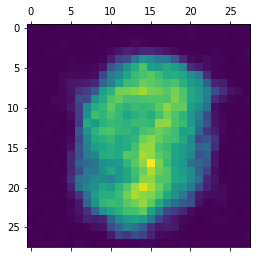

In [46]:
plt.matshow(recon_mean[3, :, :].detach())